# Updates for Marty - July 22nd

### Revising the speed-density curve
In the previous version of the model (July 8th troubleshoot), we were calculating fluxes with the following equations:
$$
\mathrm{EnFlx}(kp, kc, γ, α, kc_{jam}) = \exp(-α * kc_{jam} * kc) * kp * γ * time\_rescale \\
\mathrm{ExFlx}(kc, kc_{jam}) = \exp(-kc_{jam} * kc) * kc * time\_rescale
$$

And calculating space-mean speeds with the following speed-density curve
$$
v = \frac{v_f \frac{( \frac{\pi}{2} - \arctan(a * (kc - kc_{jam,half})))}{\pi}}{ \frac{(\frac{\pi}{2} - \arctan(a * (0 - kc_{jam,half})))}{\pi}}
%(v_f / ((\pi / 2 - \arctan(a * (0 - C_{half}))) / \pi)) * (\pi / 2 - \arctan(a * (C - C_{half}))) / pi
$$
Which simplifies to:
$$
v = \frac{v_f ( \frac{\pi}{2} - \arctan(a * (kc - kc_{jam,half})))}{ (\frac{\pi}{2} - \arctan(a * (0 - kc_{jam,half})))}
%(v_f / ((\pi / 2 - \arctan(a * (0 - C_{half}))) / \pi)) * (\pi / 2 - \arctan(a * (C - C_{half}))) / pi
$$

Really, the flux equations should come down to
$$
q = v * k
$$
so it doesn't make sense if the `v` in our Flux equations isn't derived from the same speed-density curves that we use to compute average space-mean speeds.

In this most recent version of the model, I attempt to reconcile these two functions. My hope would be to write an external function for `v(v_f, a, kc, kc_{jam})` and then pass it to my flux functions like so
$$
\mathrm{EnFlx}(kp, kc, γ, α, kc_{jam}) = v(v_f, a, kc, kc_{jam}) * kp * γ * time\_rescale \\
\mathrm{ExFlx}(kc, kc_{jam}) = v(v_f, a, kc, kc_{jam}) * kc * time\_rescale
$$

However, `Julia` complains if I make a call to an external function within `EnFlx()` or `ExFlx()`. I've tried to decipher the various error messages but haven't gained much insight. 

### Marty, please do these things:
To reproduce these errors, go into `help_funcs / build_symbolic_model()` and try each of the following versions:
- Version 0.0: original model (flux equations completely different from the speed-density curve). Should work with no errors.

- Version 0.1: the original model, but I've put `exp( -α .* kc .* kc_jam )` in an external function called `fake_speed_density_curve()`. Causes compile-time error.
    - First line of the error: "MethodError: no method matching +(::SymbolicUtils.BasicSymbolic{Any}, ::SymbolicUtils.BasicSymbolic{Any})"

- Version 1.0: new equation for speed-density curve, typed explicitly into the flux functions (no external function). Compiles and runs. However, vehicles flow in and out of corridors so quickly that we don't ever perceive a population in the corridors (Note that the old model, `fake_speed_density_curve()`, never produced values greater than 1, whereas this new model produces values up to `v_f`, the free-flow velocity)

- Version 1.1: same as version 1, but replace `my_v_f` with `1.0` in both `EnFlx()` and `ExFlx()`. This slows down the vehicle speeds so that we can perceive population changes in the corridors. Notice that the total population (black line) is sometimes less than 1. This indicates we are losing some vehicles into "loops" (e.g. the corridor from p1 to p1), which we don't want to happen.

- Version 1.2: same as version 1.1, but now multiply the numerator by `kc_{jam,half}`, which is 1/2 of the jam-density. Why do this? We have defined "loops" to have `kc_jam = 1e9`, so `kc_half = (1 / kc_jam) / 2 = 0`. Thus, multiplying the equation by `kc_half` ensures that "loops" will never increase their population. This is a quick fix, but it doesn't make sense theoretically, because now we have changed the units of the outputs (`kc_half` has units of vehicles / space).

- Version 2.0: new equation for speed-density curve, calculated externally with the function `speed_density_curve()`. Causes compile-time error.
    - First line of the error is same as in Version 0.1: "MethodError: no method matching +(::SymbolicUtils.BasicSymbolic{Any}, ::SymbolicUtils.BasicSymbolic{Any})"

### Current takeaways
I need to figure out two main things: 
1. what is the right functional form for the speed-density curve? (Including thinking about how to ensure `v=0` when `kc_half=0`)
2. how to write the functions in a way that Julia will accept? (Writing everything explicitly, as in Version 1.0, is fine, but not easy to read)

In [7]:
# Fast call for helper functions to run model
path_to_help_funcs = "/Users/auroracossairt/opt/traffic_air_quality_modeling/julia_model/help_funcs.jl" # CHANGE FOR YOURSELF
include(path_to_help_funcs)
using .HelpFuncs
using ModelingToolkit, DifferentialEquations, Plots, LinearAlgebra

In [12]:
#=
Set initial conditions, parameters, and other arguments to pass to model solver
=#

Np = 2 # Number of patches
Nc = 1 # Number of corridors

# Set initial conditions
kp_init = [1.0; 0.0]
kc_init = zeros(Np, Np, Nc)
u_init = 1
v_init = 0

# Set timescale
my_period = 1440    # 24 hours, in minutes
my_t_end = my_period     # Change if you only want to examine part of a day (< my_period), or multiple days (> my_period)
scale = 1440 / my_period # if using a period other than 1440, this will rescale the other parameters

# Set parameters
my_α = [1]   # Tolerance for congestion (for now, assume same for patch 1 and patch 2)
kc_jam_base = 10
my_kc_jam = kc_jam_base * ones(Np, Np, Nc)  # Inverse road capacity (for now, assume same for all corridors)
my_kc_jam[[CartesianIndex(i, i, k) for i in 1:Np, k in 1:Nc]] .= 1e9 # set diagonal values to almost Inf
display(my_kc_jam)

# TEST: set C_init to C_jam
#kc_init[1,2,1] = 1 ./ my_kc_jam[1,2,1] + 0.05 # Should be 1/20
display(kc_init)

# Arguments for demand function (which is f() = L / (1 + exp(-r * (x-x0))) )
demand_function = "periodic_logistic" # Default option is "static"
my_L = 0.6
my_r = 100
my_x0 = 0.99
my_shift = 0 * 60    # in units of minutes, set to 0 for no shift

# Parameters for calculating space-mean speed
my_v_f = 90
my_a = 20

2×2×1 Array{Float64, 3}:
[:, :, 1] =
  1.0e9  10.0
 10.0     1.0e9

2×2×1 Array{Float64, 3}:
[:, :, 1] =
 0.0  0.0
 0.0  0.0

20

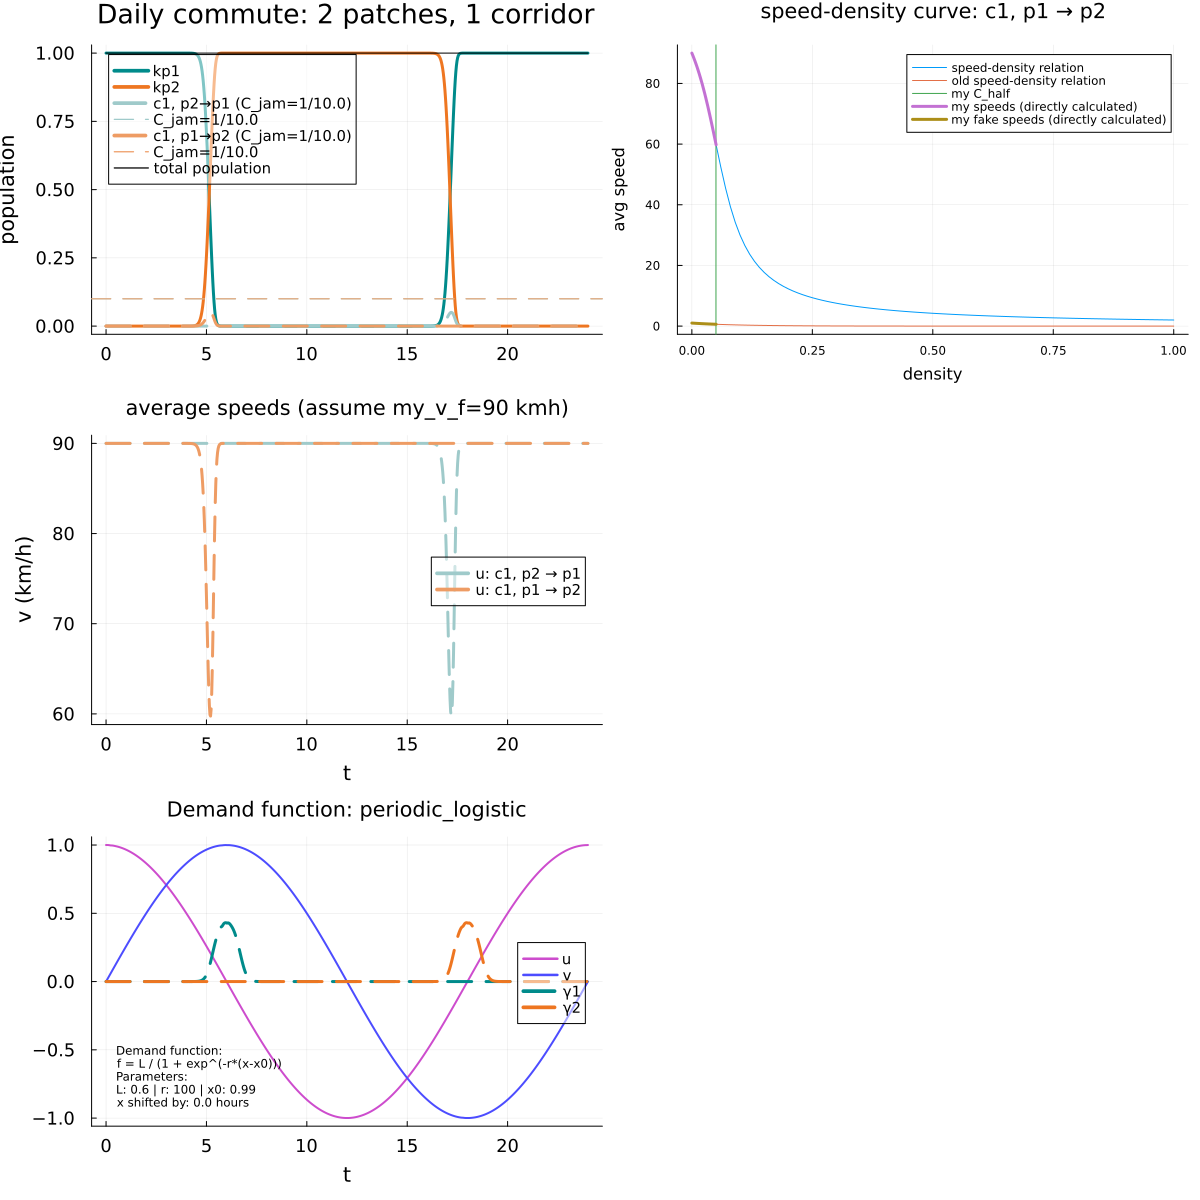

In [13]:
#=
Build model, solve problem, plot results, and save
=#

model, prob, sol, plt = HelpFuncs.build_symbolic_model(Np=Np, Nc=Nc,
    my_kp=kp_init, my_kc=kc_init, my_u=u_init, my_v=v_init, my_α=my_α, my_kc_jam=my_kc_jam,
    γ_version = demand_function, my_period = my_period, t_end = my_t_end, my_v_f=my_v_f, my_a=my_a, my_L=my_L,
    my_r=my_r, my_x0=my_x0, my_shift=my_shift)

# Suffix to specify test
suffix = "_new_speed_density_flux" #"_original" #"_shut_off_entry_flux" #"_new_speed_density" #"_shut_off_entry_flux" #"_shut_off_exit_flux"

# Save plot
if demand_function == "periodic_logistic"
    savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc" * "_kc_jam_base_$kc_jam_base" * "_t_end_$my_t_end" * "_L_$my_L" * "_r_$my_r" * "_x0_$my_x0" * "_shift_$my_shift" * "_timescale_$scale" * suffix * ".png")
else
    savefig(plt,"traffic_pop_curve_diurnal_test_" * demand_function * "_Nc_$Nc" * "_kc_jam_base_$kc_jam_base" * "_t_end_$my_t_end" * "_timescale_$scale" * suffix * ".png")
end
display(plt)